# Tookitaki Solution
Bank ABC wants to predict app score for current credit card customers. The app
score will denote a customer’s credit worthiness and help the bank in reducing
credit default risk.

The target variable denoted as Bad_flag_worst6.

 - If value is 0: it means customer has good credit history 
 - If value is 1: it means customer has falls into 30 DPD + bucket
 
### Synopysis

This notebook unfolds in the following phases

  - Getting the Data
  - Data Preparation
  - Descriptive analytics
  - Dimensionality Reduction
  - Modeling
  - Explainability
  
### Modeling
  
I will compare the predictive power of four bespoken classes of algorithms
  
  - Logistic regression (scikit-learn)
  - Random Forests (scikit-learn)
  - Boosted Trees (xgboost)


In [979]:
import numpy as np
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 100)

# Train Data Pre-Processing

In [980]:
account=pd.read_csv("C:/Users/naren/Documents/Divya/Tookitaki/test data/raw_account_70_new.csv")
data=pd.read_csv("C:/Users/naren/Documents/Divya/Tookitaki/test data/raw_data_70_new.csv",index_col="customer_no")
enquiry=pd.read_csv("C:/Users/naren/Documents/Divya/Tookitaki/test data/raw_enquiry_70_new.csv")

## 1. Data

In [981]:
data=data.dropna(thresh=(0.5*len(data)),axis=1)
df=data.copy()
df.head()

,dt_opened,entry_time,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_11,feature_12,feature_14,feature_15,feature_16,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_46,feature_47,feature_50,feature_51,feature_52,feature_53,feature_54,feature_55,feature_56,feature_58,feature_59,feature_60,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_75,feature_76,feature_77,feature_78,feature_79,Bad_label
customer_no,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,18-Apr-15,13-Apr-15,Insignia,13-Apr-15,650.0,2.0,Card Setup,14.0,500000.0,Y,IS1,0.0,159,4284,1.0,ADFPNXXXXX,3-Sep-65,98332XXXXX,N,@REDIFFMAIL.COM,1.0,2.0,NaN,Mumbai / Navi Mumbai / Thane,400610.0,1965.0,0.0,Self,Y,2.0,90000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Mumbai,400059.0,PAN Card,ADFPNXXXXX,Y,State Bank of India,0.0,1-Jun-13,17-Jun-16,1.0,21.0,Y,Y,N,Y,1965-0,21.0,15.0,400610.0,0.0,2.0,90000.0,Nov-00,21.0,R,0000-00-00,0.0,98332XXXXX,1.0,N,0
2,21-Apr-15,21-Apr-15,Insignia,21-Apr-15,760.0,1.0,Card Setup,14.0,1200000.0,Y,IS1,0.0,91,B001,1.0,AJWPRXXXXX,14-Jul-62,99455XXXXX,N,@GMAIL.COM,1.0,2.0,NaN,Bengaluru,560042.0,1969.0,0.0,Self,Y,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Bangalore,560042.0,PAN Card,AJWPRXXXXX,N,NaN,0.0,NaN,17-Jun-16,1.0,17.0,Y,Y,N,Y,1969-0,17.0,12.0,560042.0,0.0,2.0,1.0,Nov-00,17.0,R,0000-00-00,0.0,99455XXXXX,1.0,N,0
3,22-Apr-15,21-Apr-15,Insignia,21-Apr-15,774.0,1.0,Card Setup,14.0,700000.0,Y,IS1,0.0,91,B001,2.0,AFAPNXXXXX,10-Apr-66,98456XXXXX,N,@SHOBANARAYAN.COM,1.0,0.0,NaN,Bengaluru,560042.0,1966.0,0.0,Self,Y,2.0,1.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Bangalore,560042.0,PAN Card,AFAPNXXXXX,N,NaN,0.0,NaN,17-Jun-16,3.0,17.0,N,Y,N,Y,1966-0,17.0,12.0,560042.0,0.0,2.0,1.0,Nov-00,17.0,R,0000-00-00,0.0,98456XXXXX,1.0,N,0
4,25-Apr-15,15-Apr-15,Insignia,20-Apr-15,770.0,1.0,Card Setup,14.0,500000.0,Y,IS1,0.0,157,5107,1.0,AAAPDXXXXX,16-Apr-64,98220XXXXX,N,@VSNL.COM,1.0,3.0,NaN,Pune,411001.0,1988.0,0.0,Self,Y,2.0,100000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Pune,411026.0,PAN Card,AAAPDXXXXX,Y,HDFC Bank,0.0,NaN,17-Jun-16,1.0,21.0,Y,Y,N,Y,1988-0,21.0,16.0,411001.0,0.0,2.0,100000.0,Nov-00,21.0,R,6/15/65,1.0,98220XXXXX,1.0,N,0
5,6-May-15,30-Apr-15,Insignia,NaN,NaN,3.0,Card Setup,14.0,500000.0,Y,IS1,0.0,100,D016,1.0,ABEPSXXXXX,3-Jan-54,98111XXXXX,N,@REDIFFMAIL.COM,1.0,3.0,NaN,Gurgaon,122009.0,1995.0,0.0,Self,Y,2.0,300000.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,Gurgaon,122009.0,PAN Card,ABEPSXXXXX,N,NaN,0.0,NaN,17-Jun-16,1.0,13.0,Y,Y,N,Y,1995-0,13.0,3.0,122009.0,0.0,2.0,300000.0,Nov-00,13.0,R,0000-00-00,0.0,98111XXXXX,1.0,N,0


##### Extracting features from Data set

 - work_position_account_opened = difference in date opened and feature_39 (assumed: work position started date)
 - age = age of the candidate with refernce to opened date
 - savings_account_years_opened = difference in date opened and feature_53 (assumed: date at which savings account was opened)
 - activation = difference in date opened and entry_time

In [982]:
# Feature extraction

df["feature_39"]=pd.to_datetime(df["feature_39"].fillna(0).astype("int"))
df["work_position_account_opened"]=(pd.to_datetime(df["dt_opened"],format="%d-%b-%y")-(pd.to_datetime(df["feature_39"],format="%Y"))).dt.days/365
df["age"]=((pd.to_datetime(df["dt_opened"],format="%d-%b-%y")-pd.to_datetime(df["feature_21"],format="%d-%b-%y")).dt.days/365).abs()
df["age"] = df["age"].fillna(np.mean(df["age"]))
df["savings_account_years_opened"]=(pd.to_datetime(df["dt_opened"],format="%d-%b-%y")-pd.to_datetime(df["feature_53"],format="%d-%b-%y")).dt.days/365
df["activation"]=(pd.to_datetime(df["dt_opened"],format="%d-%b-%y")-pd.to_datetime(df["entry_time"],format="%d-%b-%y")).dt.days


In [983]:
# Removing duplicate columns and columns which does not contain meaningful data (through data observation)

dup_cols=["feature_24","feature_28","feature_43","feature_1","dt_opened","entry_time",
          "feature_2","feature_50","feature_5","feature_6","feature_54","feature_21",
          "feature_30","feature_39","feature_53",
          "feature_22","feature_77","feature_20","feature_47","feature_70",
          "feature_66","feature_69","feature_56","feature_64","feature_63","feature_75"]
df=df.drop(dup_cols,axis=1)

# Renaming the features as per our observation
df = df.rename(columns ={'feature_27': 'education','feature_12':"card_type","feature_3":"card_charge",
                         "feature_7":"card_limit","feature_32":"residence_type","feature_46":"proof_type",
                        "feature_51":"Bank_name","feature_35":"salary","feature_38":"designation"})
#drop_cols = ["card_type","card_charge","card_limit","proof_type","Bank_name","designation"]
#df=df.drop(drop_cols,axis=1)
df=df.reset_index()

## 2. Account

In [984]:
account.head(10)

,dt_opened,customer_no,upload_dt,acct_type,owner_indic,opened_dt,last_paymt_dt,closed_dt,reporting_dt,high_credit_amt,cur_balance_amt,amt_past_due,paymenthistory1,paymenthistory2,paymt_str_dt,paymt_end_dt,creditlimit,cashlimit,rateofinterest,paymentfrequency,actualpaymentamount
0,10-Nov-15,12265,20-Oct-15,6,1,09-Jun-13,30-Jun-14,05-Jul-14,30-Sep-15,20900.0,0,NaN,"""""""STDSTDSTDXXXXXXXXXXXXXXXSTDXXXXXXXXXXXXXXXS...",NaN,01-Sep-15,01-Jul-14,NaN,NaN,NaN,NaN,NaN
1,10-Nov-15,12265,20-Oct-15,10,1,25-May-12,06-Sep-15,NaN,03-Oct-15,16201.0,10390,NaN,"""""""0000000000000000000000000000000000000000000...","""""""000000000000000000000000000XXX0000000000000...",01-Oct-15,01-Nov-12,14000.0,1400.0,NaN,3.0,5603.0
2,10-Nov-15,12265,20-Oct-15,10,1,22-Mar-12,31-Aug-15,NaN,30-Sep-15,41028.0,34420,NaN,"""""""0000000000000000000000000000000000000000000...","""""""0000000000000000000000000000000000000000000...",01-Sep-15,01-Oct-12,NaN,NaN,NaN,NaN,NaN
3,20-Jul-15,15606,09-Jul-15,10,1,13-Jan-06,NaN,26-Jul-07,31-Jan-09,93473.0,0,NaN,"""""""1200900600600600300000000000000000000000000...",NaN,01-Jul-07,01-Feb-06,NaN,NaN,NaN,NaN,NaN
4,20-Jul-15,15606,09-Jul-15,6,1,18-Jan-15,05-May-15,NaN,31-May-15,20250.0,13500,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN
5,20-Jul-15,15606,09-Jul-15,6,1,14-Jan-15,02-May-15,NaN,31-May-15,20000.0,8000,NaN,"""""""000000000000000""""""",NaN,01-May-15,01-Jan-15,NaN,NaN,NaN,NaN,NaN
6,20-Jul-15,15606,09-Jul-15,6,1,29-Dec-14,02-May-15,NaN,31-May-15,25100.0,12550,NaN,"""""""000000000000000000""""""",NaN,01-May-15,01-Dec-14,NaN,NaN,NaN,NaN,NaN
7,20-Jul-15,15606,09-Jul-15,6,1,22-Oct-14,02-May-15,NaN,31-May-15,16690.0,2780,NaN,"""""""000000000000000000000000""""""",NaN,01-May-15,01-Oct-14,NaN,NaN,NaN,NaN,NaN
8,20-Jul-15,15606,09-Jul-15,10,1,04-Dec-12,08-May-15,NaN,31-May-15,140160.0,128407,NaN,"""""""0000000000000000000000000000000000000000000...","""""""000000000000000000000000000000000000""""""",01-May-15,01-Dec-12,140000.0,NaN,39,NaN,6516.0
9,20-Jul-15,15606,09-Jul-15,10,1,01-Aug-12,21-May-15,NaN,26-Jun-15,NaN,26879,NaN,"""""""000000000XXX000000000000030XXX0000000000000...","""""""030000000000XXX000000000000000000000000XXX0...",01-Jun-15,01-Aug-12,NaN,NaN,NaN,3.0,NaN


In [985]:
# Converting the payment history 1 column in to different columns
#ph1_1: payment history 1 and month 1
#ph1_2: payment history 1 and month 2

m=[]
for i in account["paymenthistory1"]:
    j=re.findall("...",i)
    m.append(j)

account["paymenthistory"]=pd.Series(m).values

account[['ph1_0','ph1_1', 'ph1_2', 'ph1_3', 'ph1_4',
       'ph1_5', 'ph1_6', 'ph1_7', 'ph1_8', 'ph1_9', 'ph1_10', 'ph1_11', 'ph1_12', 'ph1_13',
       'ph1_14', 'ph1_15', 'ph1_16', 'ph1_17', 'ph1_18','ph1_19']] = pd.DataFrame(account.paymenthistory.values.tolist())

account["paymenthistory2"]=account["paymenthistory2"].fillna("0")

# Converting the payment history 2 column in to different columns
#ph1_1: payment history 2 and month 1
#ph1_2: payment history 2 and month 2
k=[]
for i in account["paymenthistory2"]:
    j=re.findall("...",i)
    k.append(j)

account["paymenthistory22"]=pd.Series(k).values

account[['ph2_0','ph2_1','ph2_2','ph2_3','ph2_4','ph2_5','ph2_6','ph2_7','ph2_8','ph2_9',
    'ph2_10','ph2_11','ph2_12','ph2_13','ph2_14','ph2_15','ph2_16','ph2_17','ph2_18',"ph2_19"]] = pd.DataFrame(account.paymenthistory22.values.tolist())

account=account.drop(["paymenthistory1","paymenthistory2","paymenthistory22","paymenthistory","ph1_0","ph1_19",'ph2_0',"ph2_19"],axis=1)


In [986]:
cols=['customer_no','dt_opened',  'upload_dt', 'opened_dt', 'last_paymt_dt', 
      'closed_dt', 'reporting_dt','paymt_str_dt',
       'paymt_end_dt','acct_type', 'owner_indic','high_credit_amt', 'cur_balance_amt', 'amt_past_due', 
        'creditlimit','cashlimit', 'rateofinterest',
       'paymentfrequency', 'actualpaymentamount', 'ph1_1', 'ph1_2', 'ph1_3', 'ph1_4',
       'ph1_5', 'ph1_6', 'ph1_7', 'ph1_8', 'ph1_9', 'ph1_10', 'ph1_11', 'ph1_12', 'ph1_13',
       'ph1_14', 'ph1_15', 'ph1_16', 'ph1_17', 'ph1_18', 'ph2_1', 'ph2_2', 'ph2_3',
       'ph2_4', 'ph2_5', 'ph2_6', 'ph2_7', 'ph2_8', 'ph2_9', 'ph2_10',
       'ph2_11', 'ph2_12', 'ph2_13', 'ph2_14', 'ph2_15', 'ph2_16', 'ph2_17',
       'ph2_18']
df_account=account[cols]

#swapping columns from observation paymt_str_dt can not be greater than paymt_end_dt
df_account = df_account.rename(columns={'paymt_str_dt': 'paymt_end_dt', 'paymt_end_dt': 'paymt_str_dt'})


##### Feature Extraction from Account data set
 - days_between_open_close: difference in closed_dt and opened_dt
 - days_between_pend_pstart: difference in paymt_end_dt and paymt_str_dt
 - days_between_lastp_pstart: difference in paymt_str_dt and last_paymt_dt
 - days_between_lastp_acctopened: difference in last_paymt_dt and opened_dt
 - days_between_repr_pend: difference in reporting_dt and paymt_end_dt
 - credlimit_overdue: difference in creditlimit and amt_past_due
 - ratio_creditlimit_credit_amt: ratio of creditlimit and high_credit_amt
 - cur_bala_actual_pay: difference in actualpaymentamount and cur_balance_amt
 - utilisation_trend: [total cur_bal_amt / total credit limit]/[mean cur_bal_amt / (mean credit limit+ mean_cashlimit)]
 - ratio_curbal_creditlimit: ratio of cur_balance_amt and creditlimit

In [987]:
df_account["days_between_open_close"]=(pd.to_datetime(df_account["closed_dt"],format="%d-%b-%y")-pd.to_datetime(df_account["opened_dt"],format="%d-%b-%y")).dt.days
df_account["days_between_pend_pstart"]=(pd.to_datetime(df_account["paymt_end_dt"],format="%d-%b-%y")-pd.to_datetime(df_account["paymt_str_dt"],format="%d-%b-%y")).dt.days
df_account["days_between_lastp_pstart"]=(pd.to_datetime(df_account["paymt_str_dt"],format="%d-%b-%y")-pd.to_datetime(df_account["last_paymt_dt"],format="%d-%b-%y")).dt.days
df_account["days_between_lastp_acctopened"]=(pd.to_datetime(df_account["last_paymt_dt"],format="%d-%b-%y")-pd.to_datetime(df_account["opened_dt"],format="%d-%b-%y")).dt.days
df_account["days_between_repr_pend"]=(pd.to_datetime(df_account["reporting_dt"],format="%d-%b-%y")-pd.to_datetime(df_account["paymt_end_dt"],format="%d-%b-%y")).dt.days
df_account["credlimit_overdue"]=df_account["creditlimit"]-df_account["amt_past_due"]
df_account["ratio_creditlimit_credit_amt"]=df_account["creditlimit"]/df_account["high_credit_amt"]
df_account["cur_bala_actual_pay"]=df_account["actualpaymentamount"]-df_account["cur_balance_amt"]
df_account["utilisation_trend"]=(df_account["cur_balance_amt"]/df_account["creditlimit"])/(df_account["cur_balance_amt"].mean()/(df_account["creditlimit"].mean()+df_account["cashlimit"]))
df_account["ratio_curbal_creditlimit"]=df_account["cur_balance_amt"]/df_account["creditlimit"]

## 3. Enquiry

In [988]:
enquiry.head()

,dt_opened,customer_no,upload_dt,enquiry_dt,enq_purpose,enq_amt
0,18-Apr-15,1,21-Apr-15,19-Dec-14,2.0,3500000.0
1,18-Apr-15,1,21-Apr-15,5-Mar-14,5.0,500000.0
2,18-Apr-15,1,21-Apr-15,5-Mar-14,0.0,50000.0
3,18-Apr-15,1,21-Apr-15,22-Feb-14,10.0,50000.0
4,18-Apr-15,1,21-Apr-15,11-Jun-13,10.0,1000.0


In [989]:
# Count: number of times the customer made enquiry with respect to each account type 
table=pd.pivot_table(enquiry,index=["customer_no","enq_purpose"], aggfunc='count')
table=table[["dt_opened"]]
table.columns=["count"]
table.head()


count
customer_no enq_purpose       
1           0.0              2
            2.0              1
            5.0              1
            10.0            14
2           0.0             21

In [990]:
# enq_amt: taking mean of enq_amt by grouoing customer_no and enq_purpose
table_amount=pd.pivot_table(enquiry,index=["customer_no","enq_purpose"], aggfunc='mean')
table_amount.head()

enq_amt
customer_no enq_purpose              
1           0.0          5.000000e+04
            2.0          3.500000e+06
            5.0          5.000000e+05
            10.0         6.293929e+04
2           0.0          3.312767e+07

In [991]:
#Merging above above two dataframes
tab_enq=pd.merge(table_amount,table,left_index=True,right_index=True)
tab_enq.head()

enq_amt  count
customer_no enq_purpose                     
1           0.0          5.000000e+04      2
            2.0          3.500000e+06      1
            5.0          5.000000e+05      1
            10.0         6.293929e+04     14
2           0.0          3.312767e+07     21

In [992]:
# Total number of enquiries made with respect to each customer
tab_enq_groupby=pd.DataFrame(tab_enq.groupby(["customer_no"])["count"].sum())
tab_enq_groupby.head()

,count
customer_no,
1,18
2,68
3,1
4,34
5,2


In [993]:
# From account data: number of times the transactions made on each account type for each customer 
tab_account=df_account[["customer_no","acct_type"]]
pivot_account=pd.DataFrame(tab_account.groupby(["customer_no","acct_type"])["acct_type"].count())
pivot_account_group=pd.DataFrame(pivot_account.groupby(["customer_no"])["acct_type"].sum())
pivot_account_group.head()

,acct_type
customer_no,
1,18
2,2
3,1
4,17
5,7


##### Feature Extrcation from enquiry data set
 - enq_ratio: ratio of acct_type and sum of all transactions with all account types
 - days_between_open_enquiry: difference in dt_opened and enquiry_dt
 - mean_enquiry_days: mean of days_between_open_enquiry by grouping customer_no and enq_purpose
 

In [994]:
df_enquiry_ratio=pd.merge(tab_enq_groupby,pivot_account_group,left_index=True,right_index=True)
df_enquiry_ratio.head()
df_enquiry_ratio["enq_ratio"]=df_enquiry_ratio["acct_type"]/df_enquiry_ratio["count"]
df_enquiry_ratio=df_enquiry_ratio.reset_index()
df_enquiry_ratio=df_enquiry_ratio[["customer_no","enq_ratio"]]
enquiry["days_between_open_enquiry"]=(pd.to_datetime(enquiry["dt_opened"],format="%d-%b-%y")-pd.to_datetime(enquiry["enquiry_dt"],format="%d-%b-%y")).dt.days
enquiry_days=pd.DataFrame(enquiry.groupby(["customer_no","enq_purpose"])["days_between_open_enquiry"].mean())
enquiry_days.columns=["mean_enquiry_days"]
tab_enq=tab_enq[["enq_amt"]]

# Merging two dataframes tab_enq and enquiry_days
final_enq=tab_enq.merge(enquiry_days,left_index=True,right_index=True)
final_enq=final_enq.reset_index().head()
final_enq.columns=["customer_no","acct_type","mean_enq_amt","mean_enquiry_days"]
final_enq["acct_type"]=final_enq["acct_type"].astype("int")
final_enq.head()

,customer_no,acct_type,mean_enq_amt,mean_enquiry_days
0,1,0,5.000000e+04,1361.000000
1,1,2,3.500000e+06,120.000000
2,1,5,5.000000e+05,409.000000
3,1,10,6.293929e+04,1623.714286
4,2,0,3.312767e+07,738.142857


## Merging Data, Account, Enquiry after preprocessing

In [995]:
df_enq_account=df_account.merge(final_enq,on=["customer_no","acct_type"],how="outer").merge(df_enquiry_ratio,on="customer_no").merge(df,on="customer_no")

In [996]:
list(df_enq_account.columns)


['customer_no',
 'dt_opened',
 'upload_dt',
 'opened_dt',
 'last_paymt_dt',
 'closed_dt',
 'reporting_dt',
 'paymt_end_dt',
 'paymt_str_dt',
 'acct_type',
 'owner_indic',
 'high_credit_amt',
 'cur_balance_amt',
 'amt_past_due',
 'creditlimit',
 'cashlimit',
 'rateofinterest',
 'paymentfrequency',
 'actualpaymentamount',
 'ph1_1',
 'ph1_2',
 'ph1_3',
 'ph1_4',
 'ph1_5',
 'ph1_6',
 'ph1_7',
 'ph1_8',
 'ph1_9',
 'ph1_10',
 'ph1_11',
 'ph1_12',
 'ph1_13',
 'ph1_14',
 'ph1_15',
 'ph1_16',
 'ph1_17',
 'ph1_18',
 'ph2_1',
 'ph2_2',
 'ph2_3',
 'ph2_4',
 'ph2_5',
 'ph2_6',
 'ph2_7',
 'ph2_8',
 'ph2_9',
 'ph2_10',
 'ph2_11',
 'ph2_12',
 'ph2_13',
 'ph2_14',
 'ph2_15',
 'ph2_16',
 'ph2_17',
 'ph2_18',
 'days_between_open_close',
 'days_between_pend_pstart',
 'days_between_lastp_pstart',
 'days_between_lastp_acctopened',
 'days_between_repr_pend',
 'credlimit_overdue',
 'ratio_creditlimit_credit_amt',
 'cur_bala_actual_pay',
 'utilisation_trend',
 'ratio_curbal_creditlimit',
 'mean_enq_amt',
 'mea

In [997]:
del_cols=['dt_opened',
 'upload_dt',
 'opened_dt',
 'last_paymt_dt',
 'closed_dt',
 'reporting_dt',
 'paymt_end_dt',
 'paymt_str_dt']
final_train_Data=df_enq_account.drop(del_cols,axis=1)
print("Explanatory variables:  {}".format(len(final_train_Data.columns)-1))
print("Number of Observations: {}".format(final_train_Data.shape[0]))

final_train_Data['target'] = final_train_Data['Bad_label'].astype('category')
final_train_Data = final_train_Data.drop('Bad_label',axis=1)
# create a 'target' column for our own convenience
print("Target variable:       '{}' -> '{}'".format('Bad_label', 'target'))


Explanatory variables:  106
Number of Observations: 186046
Target variable:       'Bad_label' -> 'target'


# Descriptive Analytics

##### Payment Delays in past 18 months
Let's start by looking at the past payment delays

In [998]:
pattern = re.compile("^ph1_[0-9]+$")
pay_status_columns = [ x for x in final_train_Data.columns if (pattern.match(x))]

final_train_Data[pay_status_columns].head(10)

,ph1_1,ph1_2,ph1_3,ph1_4,ph1_5,ph1_6,ph1_7,ph1_8,ph1_9,ph1_10,ph1_11,ph1_12,ph1_13,ph1_14,ph1_15,ph1_16,ph1_17,ph1_18
0,STD,STD,STD,XXX,XXX,XXX,XXX,XXX,STD,XXX,XXX,XXX,XXX,XXX,STD,"""""""",None,None
1,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000
2,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000
3,120,090,060,060,060,030,000,000,000,000,000,000,000,000,000,000,000,000
4,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000,000
5,000,000,000,XXX,000,000,000,000,030,XXX,000,000,000,000,000,000,000,000
6,000,900,900,900,900,900,900,888,857,829,798,767,737,706,676,645,614,584
7,000,"""""""",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,000,017,000,"""""""",None,None,None,None,None,None,None,None,None,None,None,None,None,None
9,XXX,"""""""",None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


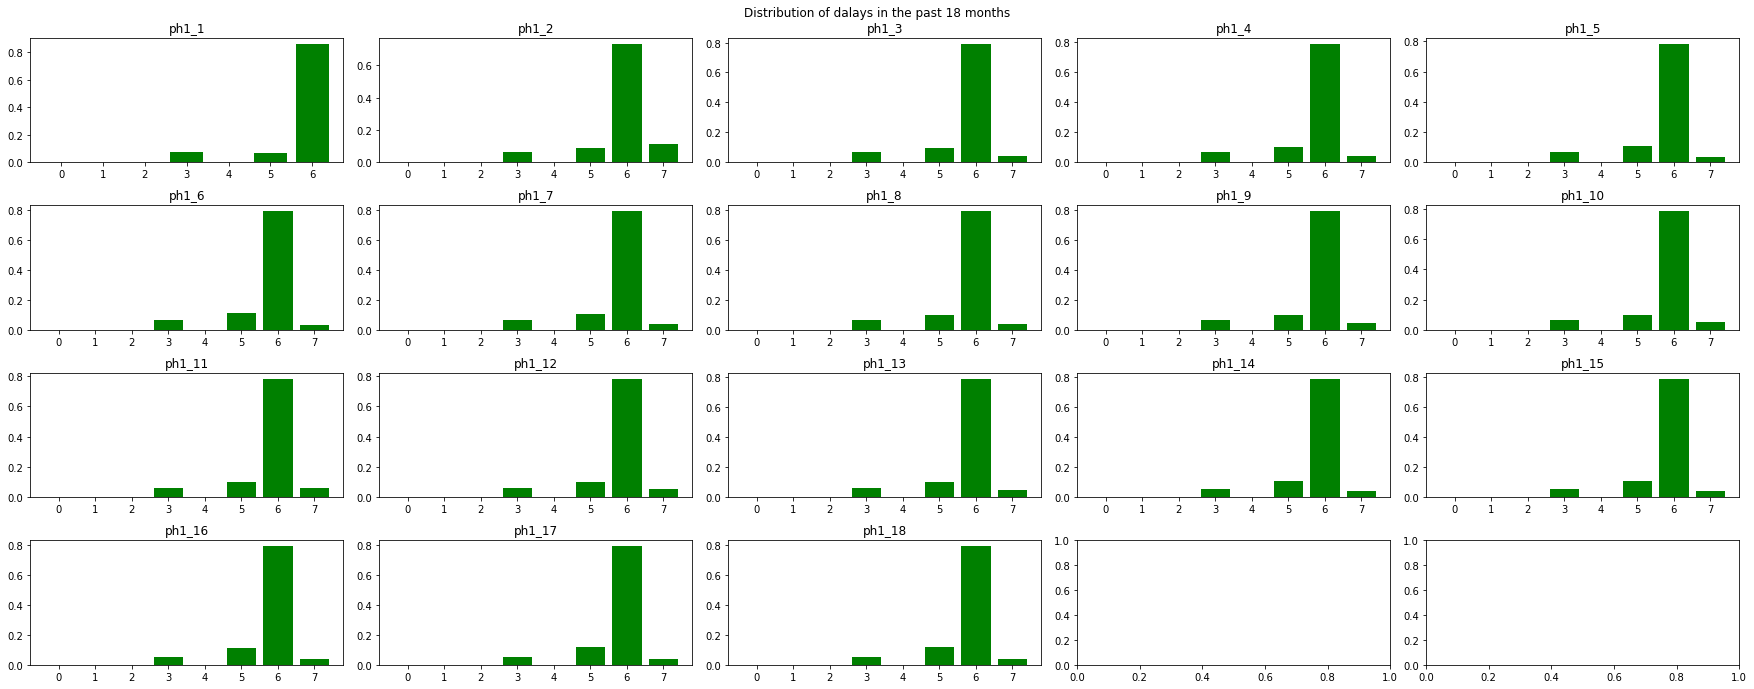

In [999]:
# pay status columns
pattern = re.compile("^ph1_[0-9]+$")
pay_status_columns = [ x for x in final_train_Data.columns if (pattern.match(x))]
plt.close("all")
fig, ax = plt.subplots(4,5)
fig.set_size_inches(25,10)
fig.suptitle('Distribution of dalays in the past 18 months')

for i in range(len(pay_status_columns)):
    row,col = int(i/5), i%5
    d = final_train_Data[pay_status_columns[i]].replace({'DBT':0,'LSS':1, 'SMA':2,'STD':3, 'SUB':4,'XXX':5,'^[0-9]':6,'"""':7},regex=True)
    d = d.value_counts()/sum(d.value_counts())
    ax[row,col].bar(d.index, d, align='center', color='g')
    ax[row,col].set_title(pay_status_columns[i])

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

As you can see most of the people had delay in payment. Most of the data is having XXX and """, not reported and no payments. Very few are having STD

In [1000]:
#describe_pay_status with target = 0
a = final_train_Data[final_train_Data['target']==0]
pay_status_target = pd.DataFrame()
for i in range(len(pay_status_columns)):
    d = a[pay_status_columns[i]].dropna()
    d  = d[d.str.match('[0-9]')].astype(int)
    d = pd.DataFrame(d.describe())

    pay_status_target = pd.concat([pay_status_target,d],axis=1)
pay_status_target   


,ph1_1,ph1_2,ph1_3,ph1_4,ph1_5,ph1_6,ph1_7,ph1_8,ph1_9,ph1_10,ph1_11,ph1_12,ph1_13,ph1_14,ph1_15,ph1_16,ph1_17,ph1_18
count,154445.000000,131528.000000,126000.000000,120881.000000,115078.000000,111332.000000,107912.000000,103649.000000,99726.000000,94470.000000,89087.000000,84210.000000,80397.000000,76844.000000,73491.000000,70309.000000,67444.000000,65010.000000
mean,1.603024,7.995415,9.653944,9.789239,9.649594,9.421406,9.401559,9.178468,9.209103,9.066264,9.043968,9.290880,9.370872,9.305892,9.398579,9.280661,9.312096,9.310937
std,22.143109,64.530238,73.733870,75.284448,75.368823,75.134730,75.350305,74.784573,75.141593,74.285588,74.545613,75.557774,75.929560,75.529153,75.899494,75.217756,75.078879,74.985106
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000


In [1001]:
#describe_pay_status with target = 1
a = final_train_Data[final_train_Data['target']==1]
pay_status_target = pd.DataFrame()
for i in range(len(pay_status_columns)):
    d = a[pay_status_columns[i]].dropna()
    d  = d[d.str.match('[0-9]')].astype(int)
    d = pd.DataFrame(d.describe())

    pay_status_target = pd.concat([pay_status_target,d],axis=1)
pay_status_target        


,ph1_1,ph1_2,ph1_3,ph1_4,ph1_5,ph1_6,ph1_7,ph1_8,ph1_9,ph1_10,ph1_11,ph1_12,ph1_13,ph1_14,ph1_15,ph1_16,ph1_17,ph1_18
count,5661.000000,4805.000000,4485.000000,4293.000000,4074.00000,3880.000000,3713.000000,3545.000000,3399.00000,3176.000000,2962.000000,2769.000000,2558.000000,2450.000000,2315.000000,2203.000000,2085.000000,1989.000000
mean,2.747571,10.653070,14.295429,14.561612,14.37948,14.086598,14.662806,13.522990,13.76699,14.049433,13.754220,15.011195,15.374120,16.307755,16.282937,16.579664,15.869065,17.759175
std,33.746258,76.138826,91.613772,94.314504,92.74311,92.429770,95.742136,93.710929,95.01050,95.190185,94.709155,100.301343,99.964168,104.004264,103.043860,104.584136,101.423362,108.415044
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,900.000000,900.000000,900.000000,900.000000,900.00000,900.000000,900.000000,900.000000,900.00000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000,900.000000


##### Standing credit
Let's look now at how the debts/credit is accumulating over the months, credit to be repaid is a positive number here.


In [1002]:
# bill columns
bill_columns = ['high_credit_amt','cur_balance_amt','amt_past_due','creditlimit','cashlimit','actualpaymentamount']
final_train_Data[bill_columns].describe()

,high_credit_amt,cur_balance_amt,amt_past_due,creditlimit,cashlimit,actualpaymentamount
count,1.771810e+05,1.860440e+05,8.750000e+02,4.875800e+04,35201.000000,4.096900e+04
mean,1.756727e+05,7.640173e+04,2.586102e+04,7.554295e+04,20613.802932,3.018164e+04
std,9.849399e+05,6.190643e+05,2.031823e+05,7.178290e+04,24873.033596,3.874615e+05
min,1.000000e+00,-7.355205e+06,1.000000e+00,1.000000e+00,1.000000,1.000000e+00
25%,2.297000e+04,0.000000e+00,1.570000e+02,3.100000e+04,7500.000000,3.112000e+03
50%,4.522100e+04,0.000000e+00,1.214000e+03,6.000000e+04,12500.000000,7.590000e+03
75%,1.060000e+05,2.097000e+04,7.683500e+03,1.000000e+05,27000.000000,1.800000e+04
max,1.800000e+08,1.360100e+08,4.869309e+06,2.500000e+06,1000000.000000,6.785322e+07


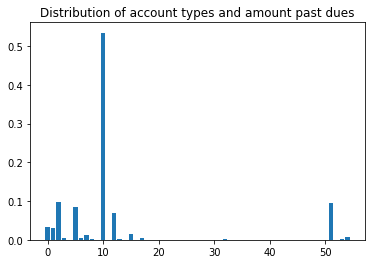

In [1003]:
# Amount past dues in each account type
acct_type_amtPastDue = pd.DataFrame(final_train_Data.groupby(['acct_type'])['amt_past_due'].sum())
acct_type_amtPastDue['amt_past_due'] = acct_type_amtPastDue['amt_past_due']/acct_type_amtPastDue['amt_past_due'].sum()
plt.close("all")
plt.title("Distribution of account types and amount past dues")
plt.bar(acct_type_amtPastDue.index,acct_type_amtPastDue['amt_past_due'])
plt.show()


Credit card transactions are having more than 50% of amount due in the past months

#### Explore Defaulting

First off, let's start with a zoomed out view on the problem.  
We want to predict defaulting, Let's answer the following questions:

  - how many cases do we have on our dataset to work with? 
  - What is the breakdown depending on some of the variables available?

Customer falls in to 30DPD+Buket is 4% out of 23896 observations


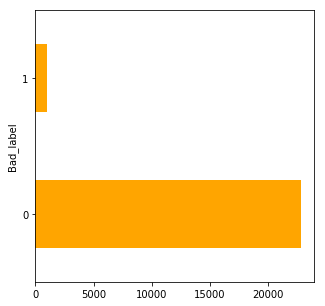

In [1004]:
plt.close("all")
fig = plt.figure()
fig.set_size_inches(5,5)
d = data.groupby(['Bad_label']).size()

print("Customer falls in to 30DPD+Buket is {}% out of {} observations".format(100* d[1]/(d[1]+d[0]), d[1]+d[0]))
p = d.plot(kind='barh', color='orange')
plt.show()

#### Explore some statistics of defaulting using the categorical variables

Let's have a look at a number of histograms to see how defaulting correlated with the categorical variables available.

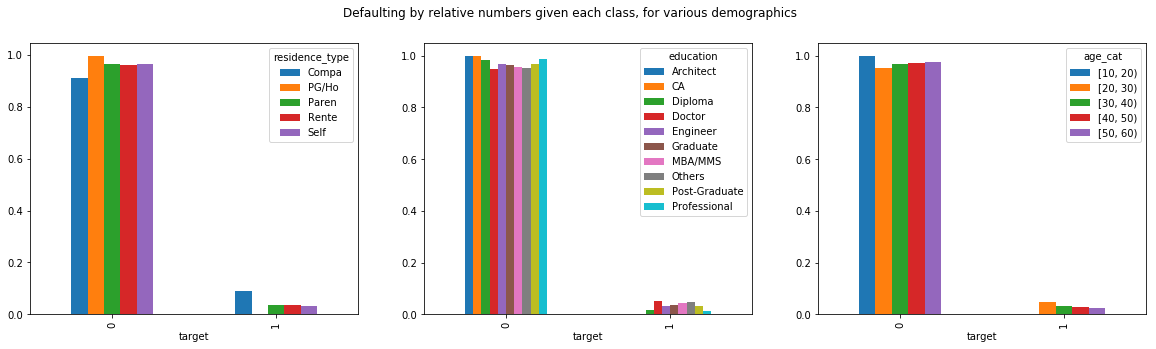

In [1005]:
final_train_Data['age_cat'] = pd.cut(final_train_Data['age'], range(0, 100, 10), right=False)
plt.close("all")
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)
fig.suptitle('Defaulting by relative numbers given each class, for various demographics')

d = final_train_Data.groupby(['target', 'residence_type']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[0])

d = final_train_Data.groupby(['target', 'education']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[1])

d = final_train_Data.groupby(['target', 'age_cat']).size().unstack(level=1)
d = d / d.sum()
p = d.plot(kind='bar', ax=ax[2])
plt.show()

### Feature engineering

It's not about blind feature conversion to values between 0 and 1, it's about understanding data. In this case we see that payment they exibits a log/log distribution, so first off, we are going to take the log of the payments.

In [1006]:
# help func
def selcols(prefix, a=1, b=18):
    return [prefix+str(i) for i in np.arange(a,b+1)]
df_train = final_train_Data.copy()

In [1007]:
from math import log


df_train['Days_Past_Due_avg_1'] = df_train[selcols('ph1_')].replace({'[A-Z]':0,'"""':0,'XXX':0,'None':0},regex=True).dropna().astype(int).mean(axis=1)
df_train['Days_Past_Due_std_1'] = df_train[selcols('ph1_')].replace({'[A-Z]':0,'"""':0,'XXX':0,'None':0},regex=True).dropna().astype(int).std(axis=1)
df_train['Days_Past_Due_avg_2'] = df_train[selcols('ph2_')].replace({'[A-Z]':0,'"""':0,'XXX':0,'None':0},regex=True).dropna().astype(int).mean(axis=1)
df_train['Days_Past_Due_std_2'] = df_train[selcols('ph2_')].replace({'[A-Z]':0,'"""':0,'XXX':0,'None':0},regex=True).dropna().astype(int).std(axis=1)
df_train['Past_Due_months_avg'] = (df_train['Days_Past_Due_avg_1']+df_train['Days_Past_Due_avg_2'])/30
df_train['Past_Due_months_std'] = (df_train['Days_Past_Due_std_1']+df_train['Days_Past_Due_std_2'])/30

In [1008]:

# average bill
df_train['bill_amt'] = df_train['cur_balance_amt']+df_train['actualpaymentamount']
       
#bill amounts relative to the limit
df_train['bill_relamt'] = df_train['bill_amt']/df_train['creditlimit']

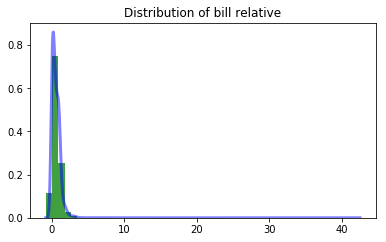

In [1009]:
from sklearn.neighbors.kde import KernelDensity

plt.figure()
plt.title('Distribution of bill relative')

d = df_train['bill_relamt'].dropna()
# the histogram of the data
n, bins, patches = plt.hist(d, 50, normed=1, facecolor='green', alpha=0.75)

# kernel density estimation
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(d.values.reshape(-1, 1))
x_grid = np.linspace(d.min(), d.max(), 1000)
log_pdf = kde.score_samples(x_grid.reshape(-1, 1))

# add the density line
plt.plot(x_grid, np.exp(log_pdf), color='blue', alpha=0.5, lw=3)

plt.tight_layout(pad=3.0, w_pad=0.5, h_pad=1.0)
plt.show()

#### Feature Scaling

In [1010]:
#Converting the data types
df_train[selcols('ph1_')]= df_train[selcols('ph1_')].replace({'[A-Z]':0,'"""':0,'XXX':0,'None':0},regex=True).dropna().astype(int)
df_train[selcols('ph2_')]= df_train[selcols('ph2_')].replace({'[A-Z]':0,'"""':0,'XXX':0,'None':0},regex=True).dropna().astype(int)


###### Label Encoding for categorical and object datatypes

In [1011]:
from sklearn.preprocessing import LabelEncoder

df_label = df_train.select_dtypes(include=['object','category'])
# Label Encoding the category variable
le=LabelEncoder()
df_label = df_label.apply(LabelEncoder().fit_transform)



###### Standardising data for float datatypes

In [1012]:
from sklearn.preprocessing import StandardScaler
df_float = df_train.select_dtypes(exclude=['object','category'])

#Replace all Nan with -1
df_float = df_float.fillna(-1)
colnames = df_float.columns
#Standardising data
scaler = StandardScaler()
df_float= pd.DataFrame(scaler.fit_transform(df_float))
df_float.columns = colnames


In [1013]:
#Getting target variable
Y_train = df_label['target']

#Join labeled data and standardised data to get Explanatory variables 
X_train = df_label.join(df_float).drop('target',axis=1)


#### Feature selection

In [1014]:
import warnings
from sklearn.feature_selection import SelectKBest, f_classif

warnings.simplefilter(action='ignore', category=(UserWarning,RuntimeWarning))

selector = SelectKBest(f_classif, 60)
selector.fit(X_train, Y_train)

SelectKBest(k=60, score_func=<function f_classif at 0x00000001A8A5F908>)

In [1015]:
top_indices = np.nan_to_num(selector.scores_).argsort()[-60:][::-1]
selector.scores_[top_indices]
cols_selected = X_train.columns[top_indices]

In [1016]:
X_train = X_train[cols_selected]
X_train.head()

,card_limit,feature_52,Bank_name,feature_14,age_cat,age,savings_account_years_opened,days_between_lastp_acctopened,enq_ratio,feature_41,feature_26,feature_79,days_between_pend_pstart,creditlimit,feature_25,feature_23,feature_62,feature_33,cashlimit,feature_36,work_position_account_opened,high_credit_amt,feature_37,feature_29,designation,card_charge,feature_34,feature_68,days_between_lastp_pstart,card_type,feature_60,feature_44,salary,feature_55,bill_amt,feature_4,Days_Past_Due_std_1,feature_58,ph2_14,ph2_9,activation,paymentfrequency,ph2_12,ph2_11,ph2_7,ph2_10,Days_Past_Due_avg_2,ph2_8,ph2_13,days_between_repr_pend,cur_balance_amt,feature_40,actualpaymentamount,ph2_4,ph2_17,ph1_3,feature_78,ph2_16,cur_bala_actual_pay,ph2_5
0,-0.851240,-0.662497,0,-0.918925,2,-0.638774,-0.772752,-0.370372,-0.991145,-0.437005,-0.726814,133,-0.258179,-0.399653,-0.425395,133,134,134,-0.288925,52280,0.828503,-0.152199,52281,-0.775536,56768,0.162694,-0.612894,-0.612894,0.765028,143,133,-0.735698,-0.034663,-0.18922,-0.055618,0.755493,-0.147878,133,-0.065658,-0.068886,-0.072751,-0.721932,-0.066826,-0.067039,-0.069570,-0.067968,-0.073546,-0.069097,-0.066716,-0.357964,-0.123415,-0.591233,-0.036469,-0.071545,-0.064467,-0.109246,-0.173854,-0.064561,0.057675,-0.070801
1,-0.851240,-0.662497,77433,-0.918925,2,-0.638774,-0.772752,0.605387,-0.991145,-0.437005,-0.726814,133,1.303095,-0.117024,-0.425395,133,134,134,-0.185146,52280,0.828503,-0.157084,52281,-0.775536,56768,0.162694,-0.612894,-0.612894,-1.308183,143,133,-0.735698,-0.034663,-0.18922,-0.026023,0.755493,-0.102848,133,-0.034948,-0.041783,-0.072751,1.386172,-0.037931,-0.038430,-0.043414,-0.040217,-0.044291,-0.042463,-0.037278,-0.405135,-0.106631,-0.591233,-0.005720,-0.047223,-0.031834,-0.092874,-0.173854,-0.033037,0.041209,-0.045843
2,-0.851240,-0.662497,77432,-0.918925,2,-0.638774,-0.772752,0.674998,-0.991145,-0.437005,-0.726814,133,1.305546,-0.399653,-0.425395,133,134,134,-0.288925,52280,0.828503,-0.131274,52281,-0.775536,56768,0.162694,-0.612894,-0.612894,-1.358020,143,133,-0.735698,-0.034663,-0.18922,-0.055618,0.755493,-0.102848,133,-0.034948,-0.041783,-0.072751,-0.721932,-0.037931,-0.038430,-0.043414,-0.040217,-0.044291,-0.042463,-0.037278,-0.357964,-0.067814,-0.591233,-0.036469,-0.047223,-0.031834,-0.092874,-0.173854,-0.033037,0.057675,-0.045843
3,-0.100039,-0.662497,77431,1.172963,2,-0.101376,-0.772752,-0.834847,-0.458651,-0.882704,0.978076,133,-0.042493,-0.399653,-0.425395,133,134,134,-0.288925,52280,-0.797774,-0.076752,52275,-0.711609,54284,0.180127,-0.612894,-0.612894,0.761041,140,133,-0.741613,0.596938,-0.18922,-0.055618,0.755493,1.603111,133,-0.065658,-0.068886,-0.597761,-0.721932,-0.066826,-0.067039,-0.069570,-0.067968,-0.073546,-0.069097,-0.066716,0.604680,-0.123415,-0.591233,-0.036469,-0.071545,-0.064467,0.889454,-0.173854,-0.064561,0.057675,-0.070801
4,-0.100039,-0.662497,77430,1.172963,2,-0.101376,-0.772752,0.228526,-0.458651,-0.882704,0.978076,133,0.854566,2.426458,-0.425395,133,134,134,-0.288925,52280,-0.797774,-0.028217,52275,-0.711609,54284,0.180127,-0.612894,-0.612894,-1.007169,140,133,-0.741613,0.596938,-0.18922,0.194047,0.755493,-0.102848,133,-0.065658,-0.068886,-0.597761,-0.721932,-0.066826,-0.067039,-0.069570,-0.067968,-0.073546,-0.069097,-0.066716,-0.356217,0.084008,-0.591233,-0.000710,-0.071545,-0.064467,-0.092874,-0.173854,-0.064561,-0.361671,-0.070801


# TEST DATA Pre-Processing

In [1017]:
account=pd.read_csv("C:/Users/naren/Documents/Divya/Tookitaki/test data/raw_account_30_new.csv")
data=pd.read_csv("C:/Users/naren/Documents/Divya/Tookitaki/test data/raw_data_30_new.csv",index_col="customer_no")
enquiry=pd.read_csv("C:/Users/naren/Documents/Divya/Tookitaki/test data/raw_enquiry_30_new.csv")

## 1. Data

data=data.dropna(thresh=(0.5*len(data)),axis=1)
df=data.copy()


##### Extracting features from Data set

# Feature extraction

df["feature_39"]=pd.to_datetime(df["feature_39"].fillna(0).astype("int"))
df["work_position_account_opened"]=(pd.to_datetime(df["dt_opened"],format="%d-%b-%y")-(pd.to_datetime(df["feature_39"],format="%Y"))).dt.days/365
df["age"]=((pd.to_datetime(df["dt_opened"],format="%d-%b-%y")-pd.to_datetime(df["feature_21"],format="%d-%b-%y")).dt.days/365).abs()
df["age"] = df["age"].fillna(np.mean(df["age"]))
df["savings_account_years_opened"]=(pd.to_datetime(df["dt_opened"],format="%d-%b-%y")-pd.to_datetime(df["feature_53"],format="%d-%b-%y")).dt.days/365
df["activation"]=(pd.to_datetime(df["dt_opened"],format="%d-%b-%y")-pd.to_datetime(df["entry_time"],format="%d-%b-%y")).dt.days


# Removing duplicate columns and columns which does not contain meaningful data (through data observation)

dup_cols=["feature_24","feature_28","feature_43","feature_1","dt_opened","entry_time",
          "feature_2","feature_50","feature_5","feature_6","feature_54","feature_21",
          "feature_30","feature_39","feature_53",
          "feature_22","feature_77","feature_20","feature_47","feature_70",
          "feature_66","feature_69","feature_56","feature_64","feature_63","feature_75"]
df=df.drop(dup_cols,axis=1)

# Renaming the features as per our observation
df = df.rename(columns ={'feature_27': 'education','feature_12':"card_type","feature_3":"card_charge",
                         "feature_7":"card_limit","feature_32":"residence_type","feature_46":"proof_type",
                        "feature_51":"Bank_name","feature_35":"salary","feature_38":"designation"})
#drop_cols = ["card_type","card_charge","card_limit","proof_type","Bank_name","designation"]
#df=df.drop(drop_cols,axis=1)
df=df.reset_index()

## 2. Account

account.head(10)

# Converting the payment history 1 column in to different columns
#ph1_1: payment history 1 and month 1
#ph1_2: payment history 1 and month 2

m=[]
for i in account["paymenthistory1"]:
    j=re.findall("...",i)
    m.append(j)

account["paymenthistory"]=pd.Series(m).values

account[['ph1_0','ph1_1', 'ph1_2', 'ph1_3', 'ph1_4',
       'ph1_5', 'ph1_6', 'ph1_7', 'ph1_8', 'ph1_9', 'ph1_10', 'ph1_11', 'ph1_12', 'ph1_13',
       'ph1_14', 'ph1_15', 'ph1_16', 'ph1_17', 'ph1_18','ph1_19']] = pd.DataFrame(account.paymenthistory.values.tolist())

account["paymenthistory2"]=account["paymenthistory2"].fillna("0")

# Converting the payment history 2 column in to different columns
#ph1_1: payment history 2 and month 1
#ph1_2: payment history 2 and month 2
k=[]
for i in account["paymenthistory2"]:
    j=re.findall("...",i)
    k.append(j)

account["paymenthistory22"]=pd.Series(k).values

account[['ph2_0','ph2_1','ph2_2','ph2_3','ph2_4','ph2_5','ph2_6','ph2_7','ph2_8','ph2_9',
    'ph2_10','ph2_11','ph2_12','ph2_13','ph2_14','ph2_15','ph2_16','ph2_17','ph2_18',"ph2_19"]] = pd.DataFrame(account.paymenthistory22.values.tolist())

account=account.drop(["paymenthistory1","paymenthistory2","paymenthistory22","paymenthistory","ph1_0","ph1_19",'ph2_0',"ph2_19"],axis=1)


cols=['customer_no','dt_opened',  'upload_dt', 'opened_dt', 'last_paymt_dt', 
      'closed_dt', 'reporting_dt','paymt_str_dt',
       'paymt_end_dt','acct_type', 'owner_indic','high_credit_amt', 'cur_balance_amt', 'amt_past_due', 
        'creditlimit','cashlimit', 'rateofinterest',
       'paymentfrequency', 'actualpaymentamount', 'ph1_1', 'ph1_2', 'ph1_3', 'ph1_4',
       'ph1_5', 'ph1_6', 'ph1_7', 'ph1_8', 'ph1_9', 'ph1_10', 'ph1_11', 'ph1_12', 'ph1_13',
       'ph1_14', 'ph1_15', 'ph1_16', 'ph1_17', 'ph1_18', 'ph2_1', 'ph2_2', 'ph2_3',
       'ph2_4', 'ph2_5', 'ph2_6', 'ph2_7', 'ph2_8', 'ph2_9', 'ph2_10',
       'ph2_11', 'ph2_12', 'ph2_13', 'ph2_14', 'ph2_15', 'ph2_16', 'ph2_17',
       'ph2_18']
df_account=account[cols]

#swapping columns from observation paymt_str_dt can not be greater than paymt_end_dt
df_account = df_account.rename(columns={'paymt_str_dt': 'paymt_end_dt', 'paymt_end_dt': 'paymt_str_dt'})


##### Feature Extraction from Account data set

df_account["days_between_open_close"]=(pd.to_datetime(df_account["closed_dt"],format="%d-%b-%y")-pd.to_datetime(df_account["opened_dt"],format="%d-%b-%y")).dt.days
df_account["days_between_pend_pstart"]=(pd.to_datetime(df_account["paymt_end_dt"],format="%d-%b-%y")-pd.to_datetime(df_account["paymt_str_dt"],format="%d-%b-%y")).dt.days
df_account["days_between_lastp_pstart"]=(pd.to_datetime(df_account["paymt_str_dt"],format="%d-%b-%y")-pd.to_datetime(df_account["last_paymt_dt"],format="%d-%b-%y")).dt.days
df_account["days_between_lastp_acctopened"]=(pd.to_datetime(df_account["last_paymt_dt"],format="%d-%b-%y")-pd.to_datetime(df_account["opened_dt"],format="%d-%b-%y")).dt.days
df_account["days_between_repr_pend"]=(pd.to_datetime(df_account["reporting_dt"],format="%d-%b-%y")-pd.to_datetime(df_account["paymt_end_dt"],format="%d-%b-%y")).dt.days
df_account["credlimit_overdue"]=df_account["creditlimit"]-df_account["amt_past_due"]
df_account["ratio_creditlimit_credit_amt"]=df_account["creditlimit"]/df_account["high_credit_amt"]
df_account["cur_bala_actual_pay"]=df_account["actualpaymentamount"]-df_account["cur_balance_amt"]
df_account["utilisation_trend"]=(df_account["cur_balance_amt"]/df_account["creditlimit"])/(df_account["cur_balance_amt"].mean()/(df_account["creditlimit"].mean()+df_account["cashlimit"]))
df_account["ratio_curbal_creditlimit"]=df_account["cur_balance_amt"]/df_account["creditlimit"]

## 3. Enquiry

enquiry.head()

# Count: number of times the customer made enquiry with respect to each account type 
table=pd.pivot_table(enquiry,index=["customer_no","enq_purpose"], aggfunc='count')
table=table[["dt_opened"]]
table.columns=["count"]
table.head()


# enq_amt: taking mean of enq_amt by grouoing customer_no and enq_purpose
table_amount=pd.pivot_table(enquiry,index=["customer_no","enq_purpose"], aggfunc='mean')
table_amount.head()

#Merging above above two dataframes
tab_enq=pd.merge(table_amount,table,left_index=True,right_index=True)
tab_enq.head()

# Total number of enquiries made with respect to each customer
tab_enq_groupby=pd.DataFrame(tab_enq.groupby(["customer_no"])["count"].sum())
tab_enq_groupby.head()

# From account data: number of times the transactions made on each account type for each customer 
tab_account=df_account[["customer_no","acct_type"]]
pivot_account=pd.DataFrame(tab_account.groupby(["customer_no","acct_type"])["acct_type"].count())
pivot_account_group=pd.DataFrame(pivot_account.groupby(["customer_no"])["acct_type"].sum())
pivot_account_group.head()

##### Feature Extrcation from enquiry data set

df_enquiry_ratio=pd.merge(tab_enq_groupby,pivot_account_group,left_index=True,right_index=True)
df_enquiry_ratio.head()
df_enquiry_ratio["enq_ratio"]=df_enquiry_ratio["acct_type"]/df_enquiry_ratio["count"]
df_enquiry_ratio=df_enquiry_ratio.reset_index()
df_enquiry_ratio=df_enquiry_ratio[["customer_no","enq_ratio"]]
enquiry["days_between_open_enquiry"]=(pd.to_datetime(enquiry["dt_opened"],format="%d-%b-%y")-pd.to_datetime(enquiry["enquiry_dt"],format="%d-%b-%y")).dt.days
enquiry_days=pd.DataFrame(enquiry.groupby(["customer_no","enq_purpose"])["days_between_open_enquiry"].mean())
enquiry_days.columns=["mean_enquiry_days"]
tab_enq=tab_enq[["enq_amt"]]

# Merging two dataframes tab_enq and enquiry_days
final_enq=tab_enq.merge(enquiry_days,left_index=True,right_index=True)
final_enq=final_enq.reset_index().head()
final_enq.columns=["customer_no","acct_type","mean_enq_amt","mean_enquiry_days"]
final_enq["acct_type"]=final_enq["acct_type"].astype("int")
final_enq.head()

## Merging Data, Account, Enquiry after preprocessing

df_enq_account=df_account.merge(final_enq,on=["customer_no","acct_type"],how="outer").merge(df_enquiry_ratio,on="customer_no").merge(df,on="customer_no")

list(df_enq_account.columns)


del_cols=['dt_opened',
 'upload_dt',
 'opened_dt',
 'last_paymt_dt',
 'closed_dt',
 'reporting_dt',
 'paymt_end_dt',
 'paymt_str_dt']
final_train_Data=df_enq_account.drop(del_cols,axis=1)
print("Explanatory variables:  {}".format(len(final_train_Data.columns)-1))
print("Number of Observations: {}".format(final_train_Data.shape[0]))

final_train_Data['target'] = final_train_Data['Bad_label'].astype('category')
final_train_Data = final_train_Data.drop('Bad_label',axis=1)
# create a 'target' column for our own convenience
print("Target variable:       '{}' -> '{}'".format('Bad_label', 'target'))

final_train_Data['age_cat'] = pd.cut(final_train_Data['age'], range(0, 100, 10), right=False)



Explanatory variables:  106
Number of Observations: 79470
Target variable:       'Bad_label' -> 'target'


In [1018]:
# help func
def selcols(prefix, a=1, b=18):
    return [prefix+str(i) for i in np.arange(a,b+1)]
df_train = final_train_Data.copy()

In [1019]:
from math import log


df_train['Days_Past_Due_avg_1'] = df_train[selcols('ph1_')].replace({'[A-Z]':0,'"""':0,'XXX':0,'None':0},regex=True).dropna().astype(int).mean(axis=1)
df_train['Days_Past_Due_std_1'] = df_train[selcols('ph1_')].replace({'[A-Z]':0,'"""':0,'XXX':0,'None':0},regex=True).dropna().astype(int).std(axis=1)
df_train['Days_Past_Due_avg_2'] = df_train[selcols('ph2_')].replace({'[A-Z]':0,'"""':0,'XXX':0,'None':0},regex=True).dropna().astype(int).mean(axis=1)
df_train['Days_Past_Due_std_2'] = df_train[selcols('ph2_')].replace({'[A-Z]':0,'"""':0,'XXX':0,'None':0},regex=True).dropna().astype(int).std(axis=1)
df_train['Past_Due_months_avg'] = (df_train['Days_Past_Due_avg_1']+df_train['Days_Past_Due_avg_2'])/30
df_train['Past_Due_months_std'] = (df_train['Days_Past_Due_std_1']+df_train['Days_Past_Due_std_2'])/30

In [1020]:

# average bill
df_train['bill_amt'] = df_train['cur_balance_amt']+df_train['actualpaymentamount']
       
#bill amounts relative to the limit
df_train['bill_relamt'] = df_train['bill_amt']/df_train['creditlimit']

#### Feature Scaling

In [1021]:
#Converting the data types
df_train[selcols('ph1_')]= df_train[selcols('ph1_')].replace({'[A-Z]':0,'"""':0,'XXX':0,'None':0},regex=True).dropna().astype(int)
df_train[selcols('ph2_')]= df_train[selcols('ph2_')].replace({'[A-Z]':0,'"""':0,'XXX':0,'None':0},regex=True).dropna().astype(int)


###### Label Encoding for categorical and object datatypes

In [1022]:
from sklearn.preprocessing import LabelEncoder

df_label = df_train.select_dtypes(include=['object','category'])
# Label Encoding the category variable
le=LabelEncoder()
df_label = df_label.apply(LabelEncoder().fit_transform)



###### Standardising data for float datatypes

In [1023]:
from sklearn.preprocessing import StandardScaler
df_float = df_train.select_dtypes(exclude=['object','category'])

#Replace all Nan with -1
df_float = df_float.fillna(-1)
colnames = df_float.columns
#Standardising data
scaler = StandardScaler()
df_float= pd.DataFrame(scaler.fit_transform(df_float))
df_float.columns = colnames


In [1024]:
#Getting target variable
Y_test = df_label['target']

#Join labeled data and standardised data to get Explanatory variables 
X_test = df_label.join(df_float).drop('target',axis=1)
X_test = X_test[cols_selected]
len(list(X_test.columns))

60

### Models
#### Logistic regression (baseline models)

In [1025]:
from sklearn import linear_model

# Create logistic regression object
regr = linear_model.LogisticRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [1026]:
y_test_pred = regr.predict(X_test)

#predicting on test data
print('Accuracy: {}'.format(np.mean(y_test_pred == Y_test)*100))

#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(Y_test,y_test_pred)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Accuracy: 96.2023405059
('Confusion Matrix : \n', array([[76452,     0],
       [ 3018,     0]], dtype=int64))
('Accuracy : ', 0)
('Sensitivity : ', 1)
('Specificity : ', 0)


#### Random Forest 
Quite popular a few years back, bootstrap aggregating ensamble of decision trees

In [1027]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, min_samples_leaf=5)
rf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [1028]:

#predicting on test data
y_test_pred = rf.predict(X_test)

print('Accuracy: {}'.format(np.mean(y_test_pred == Y_test)*100))


Accuracy: 96.2023405059


In [1029]:
#### XGBoost

In [1030]:
import xgboost as xgb
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xg_boost=xgb1.fit(X_train, Y_train)

In [1032]:
#predicting on train data
predicted_xgb_test = xg_boost.predict(X_test)


In [1045]:
print('Accuracy: {}'.format(np.mean(predicted_xgb_test == Y_test)*100))

Accuracy: 96.1897571411


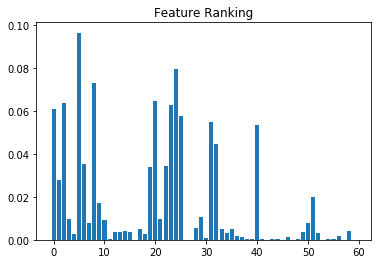

In [1035]:
# Plot for feature ranking
plt.close("all")
plt.title("Feature Ranking")
plt.bar(range(len(xgb1.feature_importances_)),xgb1.feature_importances_)
plt.show()

In [1036]:
xgb1.feature_importances_

array([  6.08122647e-02,   2.77789738e-02,   6.38270378e-02,
         9.86261293e-03,   2.79943156e-03,   9.63004455e-02,
         3.50574963e-02,   7.57999904e-03,   7.31297657e-02,
         1.69257931e-02,   9.04431753e-03,   6.02954475e-04,
         3.83306784e-03,   3.74693144e-03,   3.96227231e-03,
         3.74693144e-03,   0.00000000e+00,   4.90977196e-03,
         2.49795429e-03,   3.37654501e-02,   6.46453351e-02,
         9.60420351e-03,   3.45406793e-02,   6.25780597e-02,
         7.94177204e-02,   5.76682873e-02,   4.30681757e-05,
         0.00000000e+00,   5.46965841e-03,   1.05947712e-02,
         9.90568078e-04,   5.49119264e-02,   4.45755646e-02,
         5.25431754e-03,   3.18704499e-03,   5.25431754e-03,
         1.72272709e-03,   1.16284075e-03,   3.87613603e-04,
         3.01477237e-04,   5.35337441e-02,   3.44545406e-04,
         8.61363515e-05,   2.15340886e-04,   1.72272703e-04,
         1.29204534e-04,   1.11977255e-03,   4.30681757e-05,
         4.30681772e-04,

In [1037]:
feature_ranks = pd.DataFrame(xgb1.feature_importances_,columns=['rank'])
feature_ranks = feature_ranks.sort_values(by='rank', ascending=False)
feature_ranks['rank'].describe()

count    60.000000
mean      0.016667
std       0.025070
min       0.000000
25%       0.000377
50%       0.003812
75%       0.021771
max       0.096300
Name: rank, dtype: float64

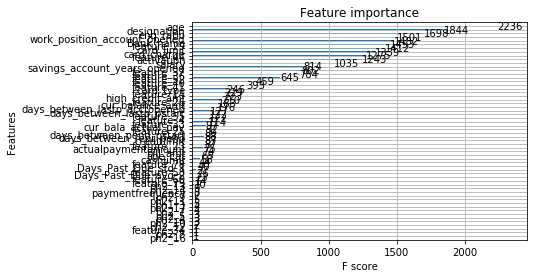

In [1044]:
# plot feature importance using built-in function
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plt.figure(figsize=(30,10))
plot_importance(xgb1)
plt.show()

# Future work

To improve accuracy by
 - Filling the missing values
 - Grid search method to tune parameters of XGBoost
 - As data is imbalance we can go for startified K fold
 - Using different thresholds to run the XGBoost model with the optimal parameters
 
I tried running above models, because of large data I could not able to complete the solution.
 